# Análisis datos Telescópio Muones ORC-CDMX

*   Elemento de la lista
*   Elemento de la lista



## Periodo de tiempo: Octubre 2024 a Septiembre de 2025

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

from datetime import datetime
from scipy.optimize import curve_fit

## Primer paso

- Aplicación del ANNA a la raw data:
    - ./raw -f -c -q 70 70 70 -w 2 <raw_file> <br>

Esto es, produce archivos de calibración .cal, aplicando un trigger en el cuarto de bin de 70 ADC y hace búsqueda de la componente muonica usando los histogramas de carga.
<br><br>
    - ./raw -f -n -u 150 150 150 <raw_file> <br>
    
Esto es: produce archivos de monitoreo .rte, aplicando un trigger en el tercer bin de 150 ADC.
<br><br>

- Procesado de los archivos .cal y .rte para obtener un único archivo con la etiqueta de tiempo presión rate "simple" y rate para filtro por muon.

### Importante: Hubo cambios en la versión de adquisición:

- Previa hasta: 2012_01_31_09h00 y 2012_01_31_19h00
- Nueva 0 desde: 2012_01_31_17h00
- Nueva 1 desde: 2012_01_31_18h00
- Nueva 1 desde: 2012_01_31_20h00 Vacio y GPS data - latitude, longitude, altitude

- Nueva 1 desde: 2012_01_31_21h00

In [ ]:
!head l1_v5_nahuelito_2012_03_01_13h00.rte

head: cannot open 'l1_v5_nahuelito_2012_03_01_13h00.rte' for reading: No such file or directory


## Histograma de carga de muestra

In [ ]:
nm_rome = open("l1_v5_nahuelito_2012_01_17_23h00.cal")

nor_ch = []
muo_ch = []

for line in nm_rome:
    tmp = line.rstrip('\n').split(' ')
    if tmp[0] != "#":
        nor_ch.append(float(tmp[2]))
        muo_ch.append(float(tmp[8]))

nor_ch = np.array(nor_ch)
muo_ch = np.array(muo_ch)

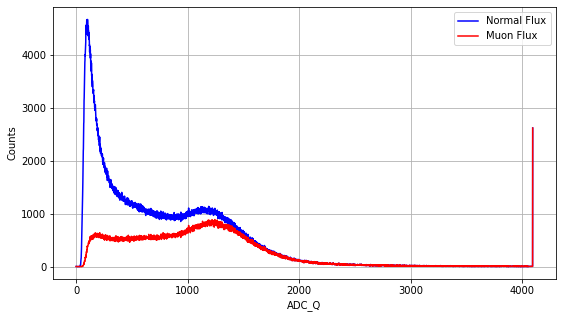

In [ ]:
fig = plt.figure(figsize=(9,5))

plt.plot(nor_ch, "-b", label="Normal Flux")
plt.plot(muo_ch, "-r", label="Muon Flux")

plt.ylabel("Counts")
plt.xlabel("ADC_Q")

plt.legend()
plt.grid()
plt.show()

## Análisis para el archivo procesado



In [ ]:
!head nahuelito_press-rate.dat

2012-01-17 19:00 917.884 601.46 300.772
2012-01-17 20:00 917.798 600.801 300.298
2012-01-17 21:00 917.88 599.666 299.754
2012-01-17 22:00 918.329 597.857 298.908
2012-01-17 23:00 919.229 596.73 298.437
2012-01-18 00:00 920.025 594.26 297.207
2012-01-18 01:00 920.635 593.856 296.827
2012-01-18 02:00 920.807 593.301 296.476
2012-01-18 03:00 920.732 594.19 296.809
2012-01-18 04:00 920.8 594.144 296.95


In [ ]:
file = open("nahuelito_press-rate.dat")

data_ra = []
data_raMu = []
data_pr = []
data_ti = []

for line in file:
    tmp = line.rstrip('\n').split(' ')

    tmp2 = datetime.strptime(tmp[0]+" "+tmp[1], "%Y-%m-%d %H:%M")
    data_ti.append( tmp2 )
    data_pr.append( float(tmp[2]) )
    data_ra.append( float(tmp[3]) )
    data_raMu.append( float(tmp[4]) )


data_ti = np.array(data_ti)
data_pr = np.array(data_pr)
data_ra = np.array(data_ra)
data_raMu = np.array(data_raMu)
data_raMu /= 9.65 # Nahuelito's total effective area

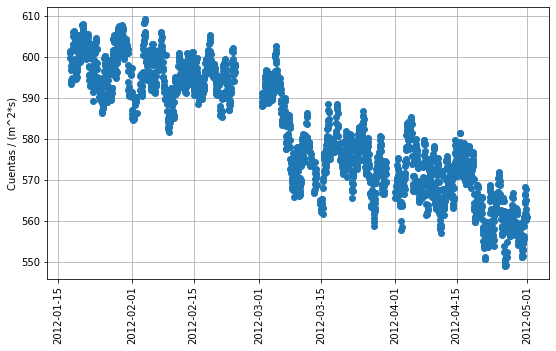

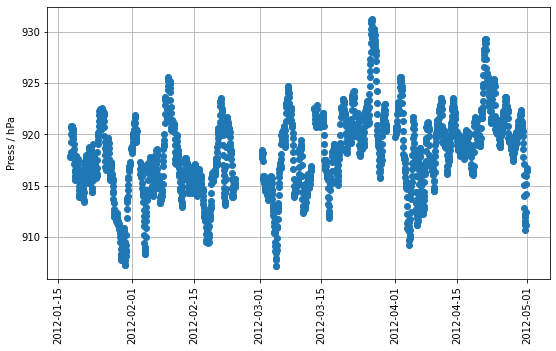

In [ ]:
fig= plt.figure(figsize=(9,5))

plt.plot(data_ti, data_ra, "o")

plt.ylabel("Cuentas / (m^2*s)")
plt.xticks(rotation=90)

plt.grid()
plt.show()


fig= plt.figure(figsize=(9,5))

plt.plot(data_ti, data_pr,"o")

plt.ylabel("Press / hPa")
plt.xticks(rotation=90)

plt.grid()
plt.show()

## Corrección por presión:
Aplicando la corrección "estándar" (https://doi.org/10.1029/2012JA018026), de tipo multiplicativas:

\begin{equation}
    \frac{\Delta{I}}{I_0} = \beta\Delta{P}\, ,
\end{equation}
donde $\Delta{I}$ es el cambio en el conteo de eventos $I$ respecto del conteo medio $I_0$ del periodo
de estudio y $\Delta{P}$ es el cambio en la presión $P$ respecto de la presión media $P_0$, mientras
$\beta$ se denominca coeficiente barométrico.

In [ ]:
i_prom = np.mean(data_ra)
p_prom = np.mean(data_pr)

deltaI = (data_ra - i_prom) / i_prom
deltaP = data_pr - p_prom

def linear(x, a):
    return a*x

pars, cov = curve_fit(linear, deltaP, deltaI, p0 = [0.])

print("===========================")
print("Beta =", pars[0]*-100,"%")
print("===========================")

Beta = 0.3734915399400977 %


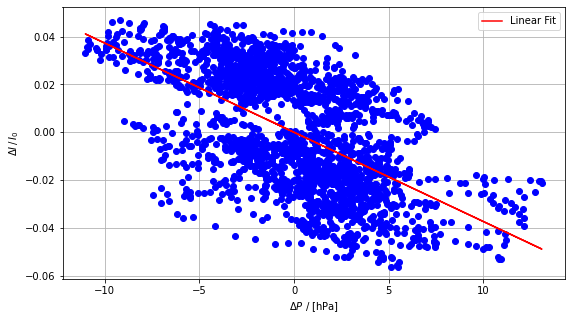

In [ ]:
fig = plt.figure(figsize=(9,5))

plt.plot(deltaP, deltaI, "ob")
plt.plot(deltaP, linear(deltaP, pars[0]), "-r", label="Linear Fit")

plt.ylabel("$\Delta I\,/\,I_0$")
plt.xlabel("$\Delta P$ / [hPa]")

plt.legend()
plt.grid()
plt.show()

En este sentido, $\beta$ se interpreta como el porcentaje de cambio en el conteo $I$ por cada hPa, es decir que el cambio relativo en la tasa de conteo $\Delta I/I_0$ es igual a

\begin{equation}
    \frac{\Delta I}{I_0} = \left( \frac{\Delta I}{I_0} \right)_ \mathrm{c} + \beta\Delta P\, ,
\end{equation}
es decir que
\begin{equation}
    \left( \frac{\Delta I}{I_0} \right)_ \mathrm{c} = \frac{\Delta I}{I_0} - \beta\Delta P\, ,
\end{equation}
donde $\left( \frac{\Delta I}{I_0} \right)_ \mathrm{c}$ representa el cambio relativo de la tasa de
conteo corregida $I_\mathrm{c}$.

Entonces,
\begin{equation}
    \left( \frac{\Delta I}{I_0} \right)_ \mathrm{c} = \frac{I_\mathrm{c} - I_0}{I_0}\, ,
\end{equation}
\begin{equation}
    I_\mathrm{c} = I_0 \left[1 + \left( \frac{\Delta I}{I_0} \right)_ \mathrm{c} \right] \, ,
\end{equation}
con $I_c$ como el conteo corregido.

In [ ]:
deltaIc = deltaI - deltaP*pars[0]
i_corr = i_prom * ( 1 + deltaIc )

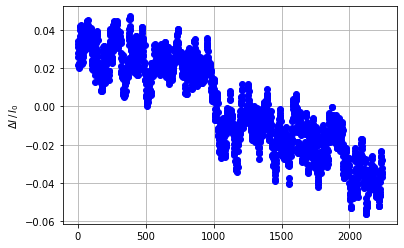

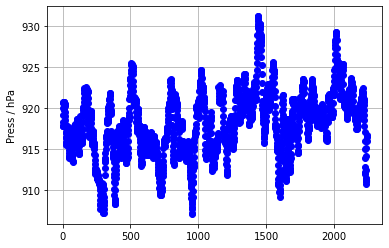

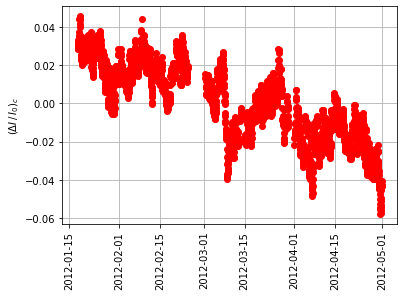

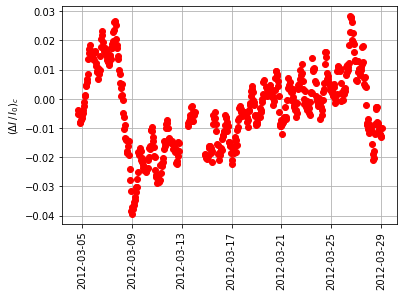

In [ ]:
plt.plot(deltaI, "ob")

plt.ylabel("$\Delta I\,/\,I_0$")
plt.grid()
plt.show()


plt.plot(data_pr, "ob", label="No corr")

plt.ylabel("Press / hPa")
plt.grid()
plt.show()


plt.plot(data_ti, deltaIc, "or", label="Corr")

plt.ylabel("$(\Delta I\,/\,I_0)_{c}$")
plt.xticks(rotation=90)

plt.grid()
plt.show()


a = 950
b = 1500
plt.plot(data_ti[a:b], deltaIc[a:b], "or", label="Corr")

plt.ylabel("$(\Delta I\,/\,I_0)_{c}$")
plt.xticks(rotation=90)

plt.grid()
plt.show()

# Para verificar esta corrección

Análisis de datos del detector de Neutrones de Roma

In [ ]:
from open_ascci import openAscci

filename = "rome_uncorr.dat"
data_no = openAscci(filename)
rmo_dte, rmo_noc = data_no.readfile2col()

filename = "rome_press.dat"
data_pr = openAscci(filename)
rmo_dte, rmo_pre = data_pr.readfile2col()

filename = "rome_corr.dat"
data_co = openAscci(filename)
rmo_dte, rmo_cor = data_co.readfile2col()

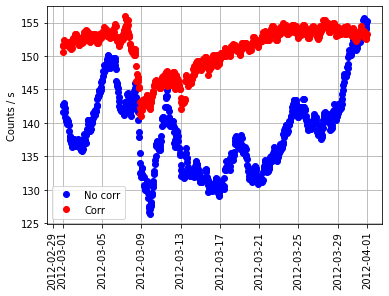

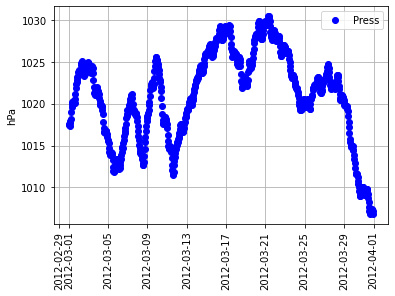

In [ ]:
plt.plot(rmo_dte, rmo_noc, "ob", label="No corr")
plt.plot(rmo_dte, rmo_cor, "or", label="Corr")

plt.ylabel("Counts / s")

plt.xticks(rotation=90)

plt.legend()
plt.grid()
plt.show()

plt.plot(rmo_dte, rmo_pre, "ob", label="Press")

plt.ylabel("hPa")

plt.xticks(rotation=90)

plt.legend()
plt.grid()
plt.show()

Estos datos fueron tomados de http://www01.nmdb.eu/nest/index.php, en azul los datos descargados sin corrección y en rojo los datos descargados con la corrección realizada por el NMDB.

Aplicando la correción descrita al inicio,

In [ ]:
i_prom = np.mean(rmo_noc)
p_prom = np.mean(rmo_pre)

deltaI = (rmo_noc - i_prom) / i_prom
deltaP = rmo_pre - p_prom

def linear(x, a):
    return a*x

pars, cov = curve_fit(linear, deltaP, deltaI, p0 = [0.])

print("===========================")
print("Beta =", pars[0]*-100,"%")
print("===========================")

Beta = 0.7161923145238207 %


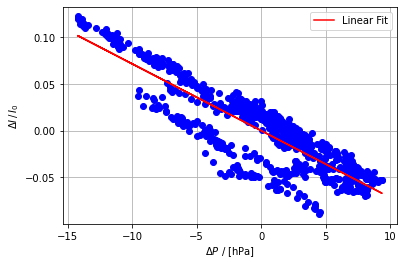

In [ ]:
plt.plot(deltaP, deltaI, "ob")
plt.plot(deltaP, linear(deltaP, pars[0]), "-r", label="Linear Fit")

plt.ylabel("$\Delta I\,/\,I_0$")
plt.xlabel("$\Delta P$ / [hPa]")

plt.legend()
plt.grid()
plt.show()

In [ ]:
deltaIc = deltaI - deltaP*pars[0]
i_corr = i_prom * ( 1 + deltaIc )

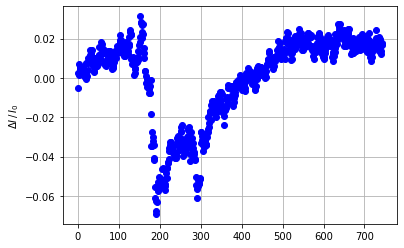

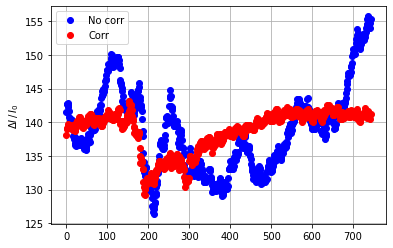

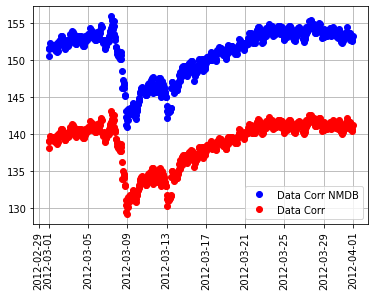

In [ ]:
plt.plot(deltaIc, "ob")

plt.ylabel("$\Delta I\,/\,I_0$")

plt.grid()
plt.show()


plt.plot(rmo_noc, "ob", label="No corr")
plt.plot(i_corr, "or", label="Corr")

plt.ylabel("$\Delta I\,/\,I_0$")

plt.legend()
plt.grid()
plt.show()

plt.plot(rmo_dte, rmo_cor, "ob", label="Data Corr NMDB")
plt.plot(rmo_dte, i_corr, "or", label="Data Corr")
plt.xticks(rotation=90)

plt.legend()
plt.grid()
plt.show()

La diferencia obserada puede estar asociada a la corrección por eficiencia de los NMDB